In [80]:
# standard library
import os
import sys
import time
import random
from itertools import cycle
import pandas as pd

# scientific / data
import numpy as np
import torch
import trimesh
import networkx as nx

# plotting / widgets
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import k3d

# progress bars
from tqdm.notebook import tqdm  # or `from tqdm import tqdm` if you prefer the console version

# SciPy / sklearn
from scipy.spatial import cKDTree, ConvexHull, Delaunay
from sklearn.decomposition import PCA

# your neural-CBF system
from neural_clbf.systems import ControlAffineSystem
from neural_clbf.controllers.cbf_controller import CBFController
from neural_clbf.controllers.controller_utils import normalize_with_angles
from neural_clbf.datamodules.episodic_datamodule import EpisodicDataModule
from neural_clbf.experiments import ExperimentSuite

from configs.get_config import get_config_from_yml
from GINN.shape_boundary_helper import ShapeBoundaryHelper
from GINN.helpers.mp_manager import MPManager
from GINN.helpers.timer_helper import TimerHelper
from GINN.morse.scc_surfacenet_manager import SCCSurfaceNetManager
from GINN.problem_sampler import ProblemSampler
from GINN.visualize.plotter_3d import Plotter3d

from train.train_utils.autoclip import AutoClip
from train.train_utils.latent_sampler import sample_new_z

from utils import get_model, get_stateless_net_with_partials, set_all_seeds, get_is_out_mask
from notebooks.notebook_utils import get_mesh_for_latent

from models.model_utils import tensor_product_xz
from cbf import CBFModel
from simple_cbf import SimpleCBFModel

from torch.func import functional_call, jacrev, jacfwd, vmap

In [81]:
# data_directory = "/scratch/rhm4nj/cral/cral-ginn/ginn/myvis/data_gen/replica/room_0_objects"
data_directory = "/scratch/rhm4nj/cral/cral-ginn/ginn/myvis/data_gen/replica/office_4_objects"
env_name = "_".join(data_directory.split("/")[-1].split("_")[:2])
points_name = "original.npy"
points = {}

print(env_name)

for dirname in sorted(os.listdir(data_directory)):
    points_path = os.path.join(data_directory, dirname, points_name)
    points[dirname] = np.load(points_path)

office_4


In [82]:
class PointsManager:
    def __init__(self, points_dict):
        """
        Args:
            points_dict: dict[str, np.ndarray], each array is (N_i, 3)
        """
        self.original_points = {k: v.copy() for k, v in points_dict.items()}
        self.translations = {k: np.zeros(3) for k in points_dict}
        self._combined_tree = None
        self._combined_tree_needs_update = True

    def _get_translated_points(self, name):
        return self.original_points[name] + self.translations[name]

    def _rebuild_combined_tree(self):
        all_points = np.vstack([
            self._get_translated_points(name) for name in self.original_points
        ])
        self._combined_tree = cKDTree(all_points)
        self._combined_tree_needs_update = False

    def move(self, name, translation):
        """Move a point cloud by translation (x, y, z)."""
        if name not in self.translations:
            raise KeyError(f"No point cloud named '{name}'")
        self.translations[name] += np.asarray(translation)
        self._combined_tree_needs_update = True

    def get_all_points(self):
        """Return all translated points from all clouds as a single (N, 3) array."""
        return np.vstack([self.get_points(name) for name in self.original_points])

    def get_points(self, name):
        """Get the current (translated) points for a named point cloud."""
        if name not in self.original_points:
            raise KeyError(f"No point cloud named '{name}'")
        return self._get_translated_points(name)

    def reset(self):
        """Reset all point clouds to their original position."""
        for name in self.translations:
            self.translations[name] = np.zeros(3)
        self._combined_tree_needs_update = True

    def get_closest_distance(self, point):
        """
        Returns the distance to the closest point across all clouds using the fastest method.
        """
        point = np.asarray(point).reshape(1, 3)

        if self._combined_tree is None or self._combined_tree_needs_update:
            self._rebuild_combined_tree()

        dist, _ = self._combined_tree.query(point)
        return dist[0]

    def plot(self, plot=None, point_size=0.02, display=False):
        """Plot all point clouds with k3d, using different colors."""
        if not plot:
            plot = k3d.plot()
        color_cycle = cycle([
            0xff0000, 0x00ff00, 0x0000ff, 0xffff00, 0xff00ff,
            0x00ffff, 0x888888, 0xff8800, 0x8800ff, 0x00ff88
        ])
        for name, pts in self.original_points.items():
            translated_pts = self.get_points(name)
            color = next(color_cycle)
            plot += k3d.points(translated_pts.astype(np.float32), color=color, point_size=point_size, name=name)
        if display:
            plot.display()
        return plot

class InteractivePlane:
    def __init__(self, point_on_plane, normal, plot, point_size=0.01, size=5, color=0x00FF00):
        self.size = size
        self.color = color
        self.plot = plot

        self.z_slider = widgets.FloatSlider(value=point_on_plane[2], min=-10, max=10, step=0.1, description="Z Height")
        self.nx_slider = widgets.FloatSlider(value=normal[0], min=-1, max=1, step=0.1, description="Normal X")
        self.ny_slider = widgets.FloatSlider(value=normal[1], min=-1, max=1, step=0.1, description="Normal Y")
        self.nz_slider = widgets.FloatSlider(value=normal[2], min=-1, max=1, step=0.1, description="Normal Z")

        self.z_slider.observe(self.update_plane, names="value")
        self.nx_slider.observe(self.update_plane, names="value")
        self.ny_slider.observe(self.update_plane, names="value")
        self.nz_slider.observe(self.update_plane, names="value")

        self.point_on_plane = np.array([point_on_plane[0], point_on_plane[1], self.z_slider.value])
        self.normal = np.array([self.nx_slider.value, self.ny_slider.value, self.nz_slider.value])
        self.mesh = self.create_plane()

        self.plot += self.mesh
        display(self.z_slider)

    def create_plane(self):
        normal = self.normal / np.linalg.norm(self.normal)
        v1 = np.cross(normal, np.array([1, 0, 0]))
        if np.linalg.norm(v1) < 1e-6:
            v1 = np.cross(normal, np.array([0, 1, 0]))
        v1 = v1 / np.linalg.norm(v1) * self.size
        v2 = np.cross(normal, v1)
        v2 = v2 / np.linalg.norm(v2) * self.size

        p1 = self.point_on_plane - v1 - v2
        p2 = self.point_on_plane + v1 - v2
        p3 = self.point_on_plane + v1 + v2
        p4 = self.point_on_plane - v1 + v2

        self.vertices = np.array([p1, p2, p3, p4], dtype=np.float32)
        faces = np.array([[0, 1, 2], [0, 2, 3]], dtype=np.uint32)

        return k3d.mesh(self.vertices, faces, color=self.color, wireframe=False, name="interactive plane")

    def update_plane(self, _):
        self.point_on_plane[2] = self.z_slider.value
        self.normal = np.array([self.nx_slider.value, self.ny_slider.value, self.nz_slider.value])
        self.normal = self.normal / np.linalg.norm(self.normal)
        self.vertices[:, 2] = self.point_on_plane[2]
        self.mesh.vertices = self.vertices
        print(self.normal, self.point_on_plane)

class InteractivePoint:
    def __init__(self, point, plot, point_size=0.1, color=0xFF0000):
        self.plot = plot
        self.color = color
        self.point_size = point_size

        self.x_slider = widgets.FloatSlider(value=point[0], min=-50, max=50, step=0.01, description="X")
        self.y_slider = widgets.FloatSlider(value=point[1], min=-50, max=50, step=0.01, description="Y")
        self.z_slider = widgets.FloatSlider(value=point[2], min=-50, max=50, step=0.01, description="Z")

        self.x_slider.observe(self.update_point, names="value")
        self.y_slider.observe(self.update_point, names="value")
        self.z_slider.observe(self.update_point, names="value")

        self.point = np.array([self.x_slider.value, self.y_slider.value, self.z_slider.value]).astype(np.float32)
        self.k3d_point = self.create_point()

        self.plot += self.k3d_point
        display(self.x_slider, self.y_slider, self.z_slider)

    def create_point(self):
        return k3d.points(positions=[self.point], point_size=self.point_size, color=self.color, name="interactive point")

    def update_point(self, _):
        self.point = np.array([self.x_slider.value, self.y_slider.value, self.z_slider.value]).astype(np.float32)
        self.k3d_point.positions = [self.point]

plot = k3d.plot()
plot.display()

# Clean previous interactive objects from plot
for obj in list(plot.objects):
    print(obj.name)
    if "interactive" in str(obj.name):
        plot -= obj

pm = PointsManager({n: p for n, p in points.items() if "ceiling" not in n})
print(pm.original_points.keys())
point_cloud = pm.get_all_points()
pm.plot(plot=plot)

# Create interactive elements
point_on_plane = np.mean(point_cloud, axis=0)
# office_3: z = -1
# room_0: -0.825
point_on_plane[2] = -1.3
normal = np.array([0, 0, 1])
my_plane = InteractivePlane(point_on_plane, normal, plot, size=5)

# initial_point = np.array([-14, 39, 0.6])
initial_point = point_cloud.mean(axis=0)
interactive_point = InteractivePoint(initial_point, plot, point_size=0.15, color=0xFF0000)

Output()

dict_keys(['0_non-plane', '1_chair', '2_chair', '3_chair', '4_chair', '5_window', '6_table', '7_chair', '9_floor'])


FloatSlider(value=-1.3, description='Z Height', max=10.0, min=-10.0)

FloatSlider(value=1.9961755978539182, description='X', max=50.0, min=-50.0, step=0.01)

FloatSlider(value=0.8396100176603946, description='Y', max=50.0, min=-50.0, step=0.01)

FloatSlider(value=-0.569986666419255, description='Z', max=50.0, min=-50.0, step=0.01)

In [83]:
def sample_inside_oriented_bbox(corners, num_points=1000):
    origin = corners[0]
    edge_x = corners[1] - corners[0]  # along x
    edge_y = corners[3] - corners[0]  # along y
    edge_z = corners[4] - corners[0]  # along z
    u = np.random.uniform(0, 1, (num_points, 1))
    v = np.random.uniform(0, 1, (num_points, 1))
    w = np.random.uniform(0, 1, (num_points, 1))
    samples = origin + u * edge_x + v * edge_y + w * edge_z
    return samples

def estimate_room_corners(point_cloud, scale=0.9):
    """
    Compute the oriented bounding box using PCA.
    
    Args:
        point_cloud (np.ndarray): Nx3 array of points
        scale (float): scale factor to shrink/expand box relative to center

    Returns:
        corners (8, 3): world-space coordinates of the bounding box corners
    """
    center = point_cloud.mean(axis=0)
    centered = point_cloud - center

    pca = PCA(n_components=3)
    pca.fit(centered)
    R = pca.components_.T  # principal axes as columns

    rotated = centered @ R
    min_corner = rotated.min(axis=0)
    max_corner = rotated.max(axis=0)

    # Scale down corners in PCA space
    scaled_min = center + scale * (min_corner @ R.T)
    scaled_max = center + scale * (max_corner @ R.T)

    corners_pca = np.array([
        [min_corner[0], min_corner[1], min_corner[2]],
        [max_corner[0], min_corner[1], min_corner[2]],
        [max_corner[0], max_corner[1], min_corner[2]],
        [min_corner[0], max_corner[1], min_corner[2]],
        [min_corner[0], min_corner[1], max_corner[2]],
        [max_corner[0], min_corner[1], max_corner[2]],
        [max_corner[0], max_corner[1], max_corner[2]],
        [min_corner[0], max_corner[1], max_corner[2]],
    ])

    # Scale corners toward the center
    corners_pca_scaled = scale * corners_pca

    # Transform back to world space
    corners_world = (corners_pca_scaled @ R.T) + center
    return corners_world

def sample_point_pairs(point_cloud, num_pairs=10, num_samples=1000, min_pcd_dist=0.5,
                       min_dist_range=[1.0, 2.0], plane=None, max_iterations=10,
                       p1=np.array([]), reverse=False, plot=None, corner_scale=0.85):
    """
    Sample pairs of points from inside a rotated bounding box or plane slice.
    """
    bbox_corners = estimate_room_corners(point_cloud, corner_scale)
    tree = cKDTree(point_cloud)
    og_p1 = p1.copy()

    def generate_candidates(plot=plot):
        plane_pt, _ = plane
        points = sample_inside_oriented_bbox(bbox_corners, num_samples)

        if plane is not None:
            points[:, 2] = plane_pt[2]
            if plot is not None:
                plot += k3d.points(points, name="canidates", point_size=0.025)
            return points
        else:
            return points

    pairs = []
    iterations = 0

    progress_bar = tqdm(total=num_pairs+1, desc="Sampling pair")

    while len(pairs) < num_pairs and iterations < max_iterations:
        candidate_points = generate_candidates()
        distances, _ = tree.query(candidate_points)
        valid_points = candidate_points[distances >= min_pcd_dist]
        remaining_points = list(valid_points)

        i = 0
        while len(remaining_points) > 1 and len(pairs) < num_pairs:
            for i, p2 in enumerate(remaining_points):
                if og_p1.shape[0] == 0:
                    p1 = random.choice(remaining_points)
                    while np.array_equal(p1, p2):
                        p1 = random.choice(remaining_points)
                else:
                    p1 = og_p1

                min_dist = random.uniform(min_dist_range[0], min_dist_range[1])
                if np.linalg.norm(p1 - p2) >= min_dist:
                    pairs.append([p1, p2])
                    remaining_points.pop(i)
                    progress_bar.update(1)
                    break

            if i > max_iterations:
                break

            i += 1

        iterations += 1

    if reverse:
        pairs = [p[::-1] for p in pairs]

    return np.array(pairs[:num_pairs])

for obj in list(plot.objects):
    to_check = ["Points", "Line", "bbox_corners", "canidates"]
    if True in [c in str(obj.name) for c in to_check]:
        plot -= obj
        print("Removing", obj.name)

# office_3: z = -1
plane = (my_plane.point_on_plane, (normal))  

# n_points = 10
# num_pairs = 100
# min_pcd_dist = 0.2
# test_traj_pairs = sample_point_pairs(point_cloud, num_pairs=num_pairs, num_samples=750, min_pcd_dist=min_pcd_dist, 
#     min_dist_range=[1, 5], plane=plane, max_iterations=500, reverse=True, plot=plot, corner_scale=0.8)

# corners = estimate_room_corners(point_cloud)
# plot += k3d.points(positions=corners.astype(np.float32), point_size=0.05, color=0x00ffff, name="bbox_corners")

# for pair in test_traj_pairs:
#     plot += k3d.points(pair, color=0xffff00, point_size=0.05)
#     plot += k3d.line(pair, color=0xffff00, width=0.05)
#     start = torch.tensor(pair[0], dtype=torch.float32)
#     goal = torch.tensor(pair[1], dtype=torch.float32)

    # waypoints = generate_safe_path(pm, start, goal, num_samples=2000)
    # print(waypoints)

    # # waypoints = pm.generate_safe_path_prm(pair[0], pair[1], N=n_points, D=min_pcd_dist)
    # # print(waypoints.shape)
    # plot += k3d.line(waypoints, color=0xffddf0, width=0.05)
    # plot += k3d.points(waypoints, color=0x00ff00, point_size=0.05)

In [ ]:
#################################################
#
#   LOADING IN DATA
#   LOADING IN DATA
#   LOADING IN DATA
#
##################################################

# objects
# model_directory = "/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/experiments/2025-04-30_11-11-10_room_0_objects_final"
model_directory = "/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/experiments/2025-04-30_12-23-59_office_4_objects_final"
# # small - WORKS with overhead
# model_directory = "/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/experiments/2025-04-28_22-06-30_room_0_single"

# # was good? not working now
# model_directory = "/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/experiments/2025-04-27_03-11-17_room_0_single"

########################################################################

# model_directory = "/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/experiments/2025-04-29_11-45-38_office_3_objects"

config_name = "config.yml"
device = 'cuda:0'

scale_name = "scale_factor.npy"
center_translation_name = "center_for_translation.npy"
bounds_name = "bounds.npy"
bounds_obj_name = "bounds_obj.npy"

config_paths = []
obj_names = []
model_paths = []
bounds=[]
bounds_objs=[]
scale_factors = []
centers_for_translations=[]

target_epoch = 990
use_best = True

dirs = os.listdir(model_directory)
dirs_sorted = sorted(dirs, key=lambda name: int(name.split('_', 1)[0]))
for dirname in dirs_sorted:
    classname = "_".join(dirname.split("_")[:2])
    dir_path = os.path.join(model_directory, dirname)
    config_path = ""
    model_path = ""
    model_max_path = ""
    max_epoch = 0

    for root, _, files in os.walk(dir_path):
        for file in files:
            if ".yml" in file:
                config_path = os.path.join(root, file)
            if ".pth" not in file: continue 

            if use_best and "best" in file:
                model_path = os.path.join(root, file)
                break

            try:
                epoch = int(file.split("_")[-1].split(".")[0])
            except:
                if 'best' not in file:
                    print("Invalid file name:", file)
                continue

            if epoch == target_epoch:
                model_path = os.path.join(root, file)

            if epoch > max_epoch:
                model_max_path = os.path.join(root, file)
                max_epoch = epoch

    if not model_path:
        if max_epoch:
            print(dirname, "Using max epoch", max_epoch)
            model_path = model_max_path
    
    if not (model_path and config_path):
        print("Nothing found for", dirname, (model_path, config_path))
        continue
 
    config_paths.append(config_path)
    obj_names.append(dirname)
    model_paths.append(os.path.join(root, model_path))

    point_path = os.path.join(data_directory, classname)
    scale_factor = torch.from_numpy(np.load(os.path.join(point_path, scale_name))).float().to(device)
    centers_for_translation = torch.from_numpy(np.load(os.path.join(point_path, center_translation_name))).float().to(device)
    bound = torch.from_numpy(np.load(os.path.join(point_path, bounds_name))).float().to(device)
    bound_obj = torch.from_numpy(np.load(os.path.join(point_path, bounds_obj_name))).float().to(device)

    bounds_objs.append(bound_obj)    
    bounds.append(bound)    
    scale_factors.append(scale_factor)    
    centers_for_translations.append(centers_for_translation)    

bounds = torch.stack(bounds)
bounds_objs = torch.stack(bounds_objs)
scale_factors = torch.stack(scale_factors)
centers_for_translations = torch.stack(centers_for_translations)

print(model_directory)
print("bounds", bounds.shape, "bounds_obj", bounds_objs.shape)
print("scale_factors", scale_factors.shape)
print("centers_for_translations", centers_for_translations.shape)
print(len(model_paths), model_paths)
print(len(config_paths), config_paths)
print(len(obj_names), obj_names)

/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/experiments/2025-04-30_11-35-11_office_3_objects_final
bounds torch.Size([11, 3, 2]) bounds_obj torch.Size([11, 3, 2])
scale_factors torch.Size([11])
centers_for_translations torch.Size([11, 3])
11 ['/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/experiments/2025-04-30_11-35-11_office_3_objects_final/0_wall/cond_siren/2025_04_30-11_35_37/2025_04_30-11_35_39-r7rhnlls_best.pth', '/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/experiments/2025-04-30_11-35-11_office_3_objects_final/1_table/cond_siren/2025_04_30-11_35_37/2025_04_30-11_35_39-16mjjc67_best.pth', '/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/experiments/2025-04-30_11-35-11_office_3_objects_final/2_table/cond_siren/2025_04_30-11_35_37/2025_04_30-11_35_39-wq19dk2a_best_242.pth', '/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/experiments/2025-04-30_11-35-11_office_3_objects_final/3_chair/cond_siren/2025_04_30-11_35_37/2025_04_30-11_35_39-bvtogly0_best_196.

In [84]:
import json
from cbf import CBFModel
from datetime import datetime

# Gather everything into plain Python types
n1 = 0
n2 = len(config_paths)

params = {
    "config_paths":           config_paths[n1:n2],
    "sub_model_paths":        model_paths[n1:n2],
    "all_scale_factors":      [sf.cpu().tolist() for sf in scale_factors][n1:n2],
    "all_center_translations":[ct.cpu().tolist() for ct in centers_for_translations][n1:n2],
    "all_bounds":             [b.cpu().tolist()  for b  in bounds_objs][n1:n2],
    "alpha":                  6,
    "mask_dist":              0.4,
    "scale":                  1,
    "cbf_lambda":             -1.25,
    "min_cbf_lambda":         -0.05,
    
    "cbf_relaxation_penalty": 5,
    "step_size":              0.1,
    "threshold":              0.25,
    "still_limit":            50,
    "max_iterations":         5000,
    "upper_bound":            5,
    "waypoints":            False,
    "max_waypoints":        6,
    "data_directory":       data_directory
}

# Write it out
with open("params.json", "w") as f:
    json.dump(params, f, indent=2)

print("Wrote params.json with", len(config_paths), "submodels.")

params['all_scale_factors']       = torch.tensor(params['all_scale_factors'],       dtype=torch.float32)
params['all_center_translations'] = torch.tensor(params['all_center_translations'], dtype=torch.float32)
params['all_bounds']              = torch.tensor(params['all_bounds'],              dtype=torch.float32)
device = 'cuda:0'
model, z_div = CBFModel.create_model(
    config_paths            = params['config_paths'],
    sub_model_paths         = params['sub_model_paths'],
    alpha                   = params['alpha'],
    device                  = device,
    all_scale_factors       = params['all_scale_factors'],
    all_center_translations = params['all_center_translations'],
    all_bounds              = params['all_bounds'],
)
model.mask_dist              = params['mask_dist']
model = model.to(device)

Wrote params.json with 11 submodels.


In [7]:
# def is_line_safe(p1, p2, points_manager, step=0.05, threshold=0.05, sdf=None, zs=None):
#     """
#     p1, p2: torch.Tensor of shape (3,)
#     """
#     direction = p2 - p1
#     dist = torch.norm(direction).item()
#     if dist == 0:
#         return True

#     direction = direction / dist
#     num_steps = int(dist / step)

#     for i in range(num_steps + 1):
#         pt = p1 + i * step * direction

#         if sdf is not None:
#             pt = pt.unsqueeze(0).float()
#             if sdf(pt, zs) <= 0:
#                 return False

#         if points_manager.get_closest_distance(pt.detach().cpu().numpy()) < threshold:
#             return False

#     return True

# def get_prm_samples(points_manager, start, goal, num_samples=1500, collision_threshold=0.05, z_range=0.5, sdf=None, zs=None, device='cpu'):
#     all_points = torch.from_numpy(points_manager.get_all_points())
#     bounds_min = all_points.min(dim=0).values
#     bounds_max = all_points.max(dim=0).values

#     samples = [start, goal]
#     while len(samples) < num_samples:
#         p = torch.rand(3) * (bounds_max - bounds_min) + bounds_min
#         p[2] = torch.rand(1) * z_range + start[2]

#         if sdf is not None:
#             pt = p.unsqueeze(0).float().to(device)
#             if sdf(pt, zs.to(device)) > 0.1:
#                 samples.append(p)

#         elif sdf is None and points_manager.get_closest_distance(p) > collision_threshold:
#             samples.append(p)

#     return samples

# def build_prm(points_manager, start, goal, num_samples=1500, neighbor_radius=1.0,
#               collision_threshold=0.05, z_range=0, sdf=None, zs=None, device='cpu', samples=None):
#     """
#     start, goal: torch.Tensor of shape (3,)
#     """

#     if not samples:
#         samples = get_prm_samples(points_manager, start, goal, num_samples, collision_threshold, z_range, sdf, zs, device)
#     samples_tensor = torch.stack(samples)  # shape (N, 3)
#     samples_np = samples_tensor.detach().cpu().numpy()  # for KDTree / networkx

#     tree = cKDTree(samples_np)
#     graph = nx.Graph()

#     for i, p in enumerate(samples_tensor):
#         graph.add_node(i, pos=p)
#         dists, indices = tree.query(samples_np[i], k=15)
#         for j in indices:
#             if i == j:
#                 continue
#             q = samples_tensor[j]
#             if is_line_safe(p, q, points_manager, threshold=collision_threshold, sdf=sdf, zs=zs):
#                 weight = torch.norm(p - q).item()
#                 graph.add_edge(i, j, weight=weight)

#     return graph, samples_tensor

# def find_path(graph, samples, start, goal, max_waypoints=None):
#     start_idx, goal_idx = 0, 1
#     try:
#         path_indices = nx.shortest_path(graph, source=start_idx, target=goal_idx, weight='weight')
#         path = samples[path_indices]  # tensor slicing

#         if max_waypoints is not None and len(path) > max_waypoints:
#             idxs = torch.linspace(0, len(path) - 1, steps=max_waypoints).long()
#             path = path[idxs]

#         return path
#     except nx.NetworkXNoPath:
#         return None

# def generate_safe_path(points_manager, start, goal, num_samples=500, threshold=0.05,
#                        max_waypoints=None, sdf=None, zs=None, device='cpu', point_samples=None):

#     if not point_samples is None:
#         point_samples = get_prm_samples(
#             points_manager, start, goal,
#             num_samples=num_samples,
#             collision_threshold=threshold,
#             z_range=1e-10,
#             sdf=sdf,
#             zs=zs,
#             device=device
#         )

#     graph, samples = build_prm(
#         points_manager, start, goal,
#         num_samples=num_samples,
#         collision_threshold=threshold,
#         sdf=sdf,
#         zs=zs,
#         device=device,
#         samples=point_samples
#     )

#     path = find_path(graph, samples, start, goal, max_waypoints=max_waypoints)
#     return path

# def plan_single_pair(point_cloud, pm, plane, min_pcd_dist, max_waypoints, threshold, model, min_dist_range=[3, 5]):
#     while True:
#         num_pairs_left = num_pairs
#         test_traj_pairs = []
#         while num_pairs_left > 0:
#             test_traj_pairs_tmp = sample_point_pairs(point_cloud, num_pairs=num_pairs_left, num_samples=750, min_pcd_dist=min_pcd_dist, 
#                 min_dist_range=min_dist_range, plane=plane, max_iterations=5000, reverse=True, plot=None, corner_scale=0.8)

#             test_traj_pairs.append(test_traj_pairs_tmp)
#             break

#             start_positions = torch.tensor(test_traj_pairs_tmp[:, 0, :], dtype=torch.float32)
#             goal_positions = torch.tensor(test_traj_pairs_tmp[:, 1, :], dtype=torch.float32)

#             z_inputs = torch.full((start_positions.shape[0], 1), z_div.item())
#             V_starts = model(start_positions, z_inputs)
#             V_goals = model(goal_positions, z_inputs)
#             mask = ((V_starts > 0.01) & (V_goals > 0.01))
#             if len(mask.shape) > 1:
#                 mask = mask.squeeze(1)
#             test_traj_pairs_tmp = test_traj_pairs_tmp[mask.cpu().numpy()]

#             test_traj_pairs.append(test_traj_pairs_tmp)
#             num_pairs_left -= len(test_traj_pairs_tmp)
#             print("Left:", num_pairs_left)

#         traj_pairs = np.vstack(test_traj_pairs)
#         start_positions = traj_pairs[:, 0, :]
#         goal_positions = traj_pairs[:, 1, :]

#         start = torch.tensor(start_positions[0], dtype=torch.float32)
#         goal = torch.tensor(goal_positions[0], dtype=torch.float32)

#         waypoints = generate_safe_path(
#             pm, start, goal,
#             num_samples=2000,
#             max_waypoints=max_waypoints,
#             threshold=threshold
#         )

#         if waypoints is not None:
#             return traj_pairs, waypoints

In [8]:
# import time
# from tqdm import tqdm
# from concurrent.futures import ProcessPoolExecutor, as_completed
# from joblib import Parallel, delayed
# import yaml
# import pandas as pd

# # from cbf import CBFModel
# from neural_clbf.controllers.simple_neural_cbf_controller import SimpleNeuralCBFController
# from neural_clbf.systems.simple3d import Simple3DRobot

# #################################################
# #
# #   TRAJECTORIES
# #   TRAJECTORIES
# #   TRAJECTORIES
# #
# ##################################################

# device = 'cuda:0'
# n1 = 0
# n2 = len(config_paths) - 2
# use_adapters = False

# do_optimal = False
# max_attempts = 10
# num_pairs = 32
# max_waypoints = 100
# min_pcd_dist = 0.125
# plane = (my_plane.point_on_plane, (my_plane.normal))  # Plane centered at (5,5,5), normal along Z
# # initial_point = np.array([-14.4, 39, 0.6])
# all_paths = []
# min_dist_range = [2.5, 7]

# model, z_div = CBFModel.create_model(config_paths[n1:n2], model_paths[n1:n2], alpha=2, device=device, 
#     all_scale_factors=scale_factors[n1:n2], all_center_translations=centers_for_translations[n1:n2], all_bounds=bounds_objs[n1:n2], use_adapters=use_adapters)
# print(obj_names[n1:n2])
# print("z_div", z_div, z_div.shape)

# spectral_norm = model.compute_spectral_norm()
# print("spectral_norm", spectral_norm)

# all_bounds = model.bounds
# all_scale_factors = model.scale_factors
# all_center_translations = model.centers_for_translations

# print('bounds', all_bounds.shape, bounds_objs.shape, bounds.shape)
# print(model.centers_for_translations.shape)
# print(model.scale_factors.shape)
# print("z_div", z_div)

# if do_optimal:
#     point_samples = get_prm_samples(
#             pm, start, goal,
#             num_samples=2000,
#             collision_threshold=min_pcd_dist,
#             z_range=0
#     )
#     zs = torch.full((start.shape[0], 1), z_div.item(), dtype=torch.float32)

#     test_traj_pairs = []
#     results = Parallel(n_jobs=-1)(
#         delayed(plan_single_pair)(
#             point_cloud, pm, plane, min_pcd_dist, max_waypoints, min_pcd_dist, model, min_dist_range
#         )
#         for _ in tqdm(range(num_pairs), desc="Planning trajectories in parallel")
#     )

#     test_traj_pairs, all_paths = zip(*results)
#     test_traj_pairs = list(test_traj_pairs)
#     all_paths = list(all_paths)
#     test_traj_pairs = np.concatenate(test_traj_pairs, axis=0)
#     print("all_paths", len(all_paths), all_paths)
# else:
#     bboxes = [
#         (torch.tensor([2.75, -0.5, -1.8]), torch.tensor([4.4, -0.5, -1.0])),
#     ]

#     num_pairs_left = num_pairs
#     test_traj_pairs = []
#     while num_pairs_left > 0:
#         # 1) sample raw pairs
#         test_traj_pairs_tmp = sample_point_pairs(
#             point_cloud,
#             num_pairs=num_pairs_left,
#             num_samples=750,
#             min_pcd_dist=min_pcd_dist,
#             min_dist_range=min_dist_range,
#             plane=plane,
#             max_iterations=5000,
#             reverse=True,
#             plot=None,
#             corner_scale=0.8
#         )

#         # 2) turn starts/goals into torch tensors for V-score & box tests
#         start_positions = torch.tensor(test_traj_pairs_tmp[:, 0, :], dtype=torch.float32)
#         goal_positions  = torch.tensor(test_traj_pairs_tmp[:, 1, :], dtype=torch.float32)

#         # 3) V-score filter
#         z_inputs = torch.full((start_positions.shape[0], 1), z_div.item())
#         V_starts = model(start_positions, z_inputs)
#         V_goals  = model(goal_positions,  z_inputs)
#         mask_v   = ((V_starts > 1e-3) & (V_goals > 1e-3)).detach().cpu()
#         if mask_v.dim() > 1:
#             mask_v = mask_v.squeeze(1)     # shape [N]

#         # 4) box filter: build a mask of any point INSIDE _any_ bbox
#         mask_box = torch.zeros_like(mask_v, dtype=torch.bool)
#         for bl, tr in bboxes:
#             bl, tr = bl, tr
#             inside_start = ((start_positions >= bl) & (start_positions <= tr)).all(dim=1)
#             inside_goal  = ((goal_positions  >= bl) & (goal_positions  <= tr)).all(dim=1)
#             mask_box |= (inside_start | inside_goal)

#         # 5) combine V-score _and_ “not in box”
#         mask_final = mask_v & (~mask_box)

#         # 6) apply to your numpy pairs
#         valid_pairs = test_traj_pairs_tmp[mask_final.cpu().numpy()]

#         test_traj_pairs.append(valid_pairs)
#         num_pairs_left -= valid_pairs.shape[0]
#         print("Left:", num_pairs_left)
#         if num_pairs_left <= 0:
#             break

#         if max_attempts <= 0: break
#         max_attempts -= 1
        
#     test_traj_pairs = np.vstack(test_traj_pairs)

# print("test_traj_pairs:", test_traj_pairs.shape)

# # Extract start (N, 3) and goal (N, 3) positions
# start_positions = torch.tensor(test_traj_pairs_tmp[:, 0, :], dtype=torch.float32)
# goal_positions  = torch.tensor(test_traj_pairs_tmp[:, 1, :], dtype=torch.float32)
# z_inputs = torch.full((start_positions.shape[0], 1), z_div.item())
# # print(model(start_positions, z_inputs))
# # print(model(goal_positions, z_inputs))

# start_positions = test_traj_pairs[:, 0, :]
# goal_positions = test_traj_pairs[:, 1, :]

# # Track active indices
# active_mask = torch.ones(start_positions.shape[0], dtype=torch.bool)  # All initially active
# num_active = active_mask.sum().item()  # Count active states

# use_subset = False
# test_traj_pairs_cpy = test_traj_pairs.copy()

# # logging
# combined = np.hstack([start_positions, goal_positions])
# columns = ['start_x', 'start_y', 'start_z', 'goal_x', 'goal_y', 'goal_z']
# df = pd.DataFrame(combined, columns=columns)

# save_to = "goal_csvs"
# prefix = f"{env_name}"
# if do_optimal:
#     prefix += "_optimal"
# df.to_csv(f'{save_to}/{prefix}_start_goal.csv', index=False)

# print("saving to...", f'goal_csvs/{env_name}.csv')

In [85]:
import subprocess
import os
import time

goals_file = f"goal_csvs/{env_name}_start_goal.csv"
print(env_name)

def submit_job(i, out_dir):
    log_dir = os.path.join(out_dir, "log")
    os.makedirs(log_dir, exist_ok=True)
    stdout_path = os.path.join(log_dir, f"{i}.out")
    stderr_path = os.path.join(log_dir, f"{i}.err")
    
    cmd = [
        "sbatch",
        "--job-name", f"{i}_run_traj",
        "--output",    stdout_path,
        "--error",     stderr_path,
        # "--gres=gpu:a100:1",
        "/scratch/rhm4nj/cral/cral-ginn/slurm_scripts/run_trajs.sh",
        str(i), out_dir, goals_file
    ]
    res = subprocess.run(cmd, check=True, capture_output=True, text=True)
    # sbatch prints: “Submitted batch job 123456”
    jobid = int(res.stdout.strip().split()[-1])
    return jobid

def get_running(jobids):
    """Return the subset of jobids that are still in the queue."""
    if not jobids:
        return set()
    s = subprocess.run(
        ["squeue", "-h", "-j", ",".join(map(str, jobids))],
        check=True, capture_output=True, text=True
    )
    running = set()
    for line in s.stdout.strip().splitlines():
        parts = line.split()
        if parts:
            running.add(int(parts[0]))
    return running

# 1) make timestamped directory
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
base_dir = "/scratch/rhm4nj/cral/cral-ginn/ginn/traj_outputs"
out_dir  = os.path.join(base_dir, timestamp + "_" + env_name)
os.makedirs(out_dir, exist_ok=True)
print(f"Created directory: {out_dir}")

# 2) read goals
df = pd.read_csv(goals_file)
N  = len(df)
print(N, "total runs")

# 3) concurrency parameters
K = min(N, 30)          # max number of concurrent jobs
submitted = 0   # how many we've issued so far
jobids    = []  # list of all submitted job IDs

# 4) submit-and-monitor loop
while submitted < N or len(get_running(jobids)) > 0:
    # a) submit new jobs if we’re under the limit
    while submitted < N and len(get_running(jobids)) < K:
        jid = submit_job(submitted, out_dir)
        print(f"Submitted trajectory {submitted} as job {jid}")
        jobids.append(jid)
        submitted += 1

    # b) sleep a bit before re-checking
    time.sleep(2.5)

print("All jobs submitted and completed; logs are in", out_dir)

office_4
Created directory: /scratch/rhm4nj/cral/cral-ginn/ginn/traj_outputs/2025-04-30_23-25-04_office_4
59 total runs
Submitted trajectory 0 as job 4108847
Submitted trajectory 1 as job 4108848
Submitted trajectory 2 as job 4108849
Submitted trajectory 3 as job 4108850
Submitted trajectory 4 as job 4108851
Submitted trajectory 5 as job 4108852
Submitted trajectory 6 as job 4108853
Submitted trajectory 7 as job 4108854
Submitted trajectory 8 as job 4108855
Submitted trajectory 9 as job 4108856
Submitted trajectory 10 as job 4108857
Submitted trajectory 11 as job 4108858
Submitted trajectory 12 as job 4108859
Submitted trajectory 13 as job 4108860
Submitted trajectory 14 as job 4108861
Submitted trajectory 15 as job 4108862
Submitted trajectory 16 as job 4108863
Submitted trajectory 17 as job 4108864
Submitted trajectory 18 as job 4108865
Submitted trajectory 19 as job 4108866
Submitted trajectory 20 as job 4108867
Submitted trajectory 21 as job 4108868
Submitted trajectory 22 as job 4

KeyboardInterrupt: 

In [78]:
import glob, json

# out_dir = "/scratch/rhm4nj/cral/cral-ginn/ginn/traj_outputs/2025-04-30_18-18-01_room_0"
files = sorted(glob.glob(f"{out_dir}/traj_*.json"))
all_trajs = [json.load(open(f)) for f in files]
print(len(all_trajs))

with open(f"{out_dir}/combined_trajectories.json","w") as fo:
    json.dump(all_trajs, fo, indent=2)


# all_trajs = []
# with open(path) as f:
#     buf = ""
#     depth = 0
#     for line in f:
#         # Skip the very first '[' if present
#         if depth == 0 and line.lstrip().startswith('['):
#             line = line.lstrip()[1:]
#         buf += line
#         # Track braces to know when one object ends
#         depth += line.count('{') - line.count('}')
#         if depth == 0 and buf.strip():
#             # strip trailing commas/newlines
#             obj_text = buf.strip().rstrip(',')  
#             try:
#                 all_trajs.append(json.loads(obj_text))
#             except json.JSONDecodeError:
#                 print("Skipping malformed chunk:", obj_text[:100])
#             buf = ""

print(f"Done: {out_dir}/combined_trajectories.json created.")

60
Done: /scratch/rhm4nj/cral/cral-ginn/ginn/traj_outputs/2025-04-30_22-01-05_office_3/combined_trajectories.json created.


In [79]:
import os
import json
import numpy as np
from collections import defaultdict

goals_file = f"goal_csvs/{env_name}_start_goal.csv"
# out_dir = "/scratch/rhm4nj/cral/cral-ginn/ginn/traj_outputs/2025-04-30_18-18-01_room_0"
combined_path = os.path.join(out_dir, "combined_trajectories.json")
with open(combined_path, "r") as f:
    all_trajs = json.load(f)

# 2) rebuild inactivation_reasons and durations dicts
inactivation_reasons = {}
durations = {}

total_durations = 0
total_step_times = 0
total_total_time = 0
for rec in all_trajs:
    idx = rec["trajectory_index"]
    inactivation_reasons[idx] = rec["reason"]
    durations[idx] = rec["duration"]

    total_durations += durations[idx]
    total_step_times += durations[idx] * rec["avg_step_time"]
    total_total_time += rec["total_time"]

print("Stats for", env_name)
print("Avg Total Time:", total_total_time / len(all_trajs))
print("Avg Step Time:", total_step_times / total_durations)

# 3) tally up failure reasons
reason_counts = defaultdict(list)
for idx, reason in inactivation_reasons.items():
    reason_counts[reason].append(idx)

for reason, indices in reason_counts.items():
    print(f"{reason} {len(indices)}: {sorted(indices)}")
print("durations", durations)

# 4) unpack each trajectory’s steps into numpy arrays
all_trajectories = {}
all_values       = {}
all_lie_g        = {}
all_lie_f        = {}
all_urefs        = {}
all_u            = {}

for rec in all_trajs:
    steps = rec["steps"]
    T     = rec["duration"] + 1
    traj_idx = rec["trajectory_index"]

    # stack and truncate at T
    all_trajectories[traj_idx] = np.array([s["state"] for s in steps])[:T]
    all_values[traj_idx] = np.array([s["value"] for s in steps])[:T]
    all_lie_g[traj_idx] = np.array([s["lie_g"] for s in steps])[:T]
    all_lie_f[traj_idx] = np.array([s["lie_f"] for s in steps])[:T]
    all_urefs[traj_idx] = np.array([s["u_ref"] for s in steps])[:T]
    all_u[traj_idx] = np.array([s["u"] for s in steps])[:T]

# 5) pick one to inspect
target_index = 5

# From room_0: Removed for being invalid - [13, 26, 39, 40, 52, 55, 57, 7, 29]
# cleaned_df = df.drop(index=[7, 29])
# cleaned_df.to_csv('output.csv', index=False)

trajectory        = all_trajectories[target_index]
trajectory_values = all_values      [target_index]
trajectory_lie_g  = all_lie_g       [target_index]
trajectory_lie_f  = all_lie_f       [target_index]
trajectory_urefs  = all_urefs       [target_index]
trajectory_us     = all_u           [target_index]

print("\ntarget_index", target_index, "Durations:", durations[target_index])

# now you have exactly the same six output variables as before:
#    trajectory, trajectory_values, trajectory_lie_g, trajectory_lie_f,
#    trajectory_urefs, trajectory_us

df = pd.read_csv(goals_file)
print(trajectory[0])
start_positions = df[['start_x','start_y','start_z']].values.tolist()
goal_positions  = df[['goal_x' ,'goal_y' ,'goal_z' ]].values.tolist()

Stats for office_3
Avg Total Time: 153.36101034084956
Avg Step Time: 0.07000760387365701
stopped_moving 25: [0, 1, 2, 4, 5, 9, 10, 19, 24, 25, 27, 29, 36, 38, 39, 43, 44, 45, 46, 49, 50, 51, 53, 57, 58]
goal_reached 34: [3, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 28, 30, 31, 32, 33, 34, 35, 37, 40, 41, 42, 47, 48, 52, 54, 55, 56, 59]
unsafe_region 1: [26]
durations {0: 1302, 1: 777, 2: 3065, 3: 1062, 4: 3312, 5: 1656, 6: 3597, 7: 2697, 8: 2370, 9: 846, 10: 904, 11: 3040, 12: 2069, 13: 2621, 14: 1084, 15: 2581, 16: 1618, 17: 2617, 18: 2316, 19: 847, 20: 2281, 21: 1039, 22: 2198, 23: 1791, 24: 2528, 25: 1230, 26: 0, 27: 1194, 28: 1877, 29: 1971, 30: 1291, 31: 3127, 32: 2249, 33: 1202, 34: 1463, 35: 2296, 36: 769, 37: 2577, 38: 1569, 39: 1553, 40: 2096, 41: 1643, 42: 1181, 43: 1250, 44: 1556, 45: 910, 46: 1025, 47: 2386, 48: 1439, 49: 1864, 50: 1088, 51: 1254, 52: 2558, 53: 2889, 54: 1886, 55: 1852, 56: 1571, 57: 848, 58: 2964, 59: 2834}

target_index 5 Durations: 1656
[-

In [47]:
import pandas as pd

def downsample_point_cloud_random(point_cloud, num_points):
    if point_cloud.shape[0] <= num_points:
        return point_cloud  # Already small enough

    indices = np.random.choice(point_cloud.shape[0], num_points, replace=False)
    return point_cloud[indices]

# def print_model_attributes(m):
#     for name, val in sorted(vars(m).items()):
#         print(f"{name}: {val}")
# print_model_attributes(model)

new_plot = k3d.plot(camera_auto_fit=False)
new_plot.display()
# model.reset_submodels()

print("z_div", z_div)

hide_top = [i for i in range(len(model.configs)) if i != 12]
model.set_submodels(hide_top)
# model.reset_submodels()
model.bounds = torch.stack(model.bounds,      dim=0).to(model.device)  # shape (M,2,3)
model.scale_factors = torch.stack(model.scale_factors,      dim=0).to(model.device)
model.centers_for_translations = torch.stack(model.centers_for_translations, dim=0).to(model.device)


model.mask_disk = 0.4
model.alpha = 6
CBFModel.update_plot(model, z_div, new_plot, mc_resolution=80, w=25)


new_plot.camera = [3.467074093287802, 1.5136175779222774, 5.52609292970741, 3.7041622184074083, 1.3540040518051255, -0.33680367107978, -0.016295361574148355, 0.9994867344945908, 0.02758131179815139]


# pm.plot(plot)
small_pcd = downsample_point_cloud_random(point_cloud, min(point_cloud.shape[0], 200000))
# new_plot += k3d.points(positions=small_pcd.astype(np.float32), point_size=0.01, color=0xff0000)
new_plot += k3d.points(positions=small_pcd.astype(np.float32), point_size=0.01)

point_size = 0.15
do_optimal = False
if do_optimal:
    for i, p in enumerate(all_paths):
        if i != target_index: continue
        new_plot += k3d.line(p, color=0xaaddaa, width=0.05)
        new_plot += k3d.points(p, color=0xaaddaa, point_size=point_size)
        new_plot += k3d.points(wp_targets[i], color=0x00AFFa, point_size=point_size)


new_plot += k3d.points(positions=[trajectory[0], trajectory[-1]], point_size=point_size)


# start - aqua
point = k3d.points(positions=start_positions[target_index], point_size=point_size, color=0x00FFFF)
new_plot += point

# goal - green
goal_point = k3d.points(positions=goal_positions[target_index], point_size=point_size, color=0x00FF00)
new_plot += goal_point

trajectories = {}
# start_pt_new = [2.75, -0.5, -1.8]
# end_pt_new = [4.4, -0.5, -1]

# start_pt_new = small_pcd.mean(axis=0)
# new_interactive_point = InteractivePoint(start_pt_new, new_plot, point_size=0.15, color=0xFFFF00)
# new_interactive_point = InteractivePoint(end_pt_new, new_plot, point_size=0.15, color=0xFF0FF0)

Output()

z_div tensor([1.], device='cuda:0')


In [48]:
print(new_plot.camera)

[3.467074093287802, 1.5136175779222774, 5.52609292970741, 3.7041622184074083, 1.3540040518051255, -0.33680367107978, -0.016295361574148355, 0.9994867344945908, 0.02758131179815139]


In [64]:
import uuid
from copy import deepcopy

show_fails = True
show_passes = True

def add_trajectory(plot, points: np.ndarray, name: str = None, color=0x0fff00, width=0.05, show_points = True):
    if name is None:
        name = str(uuid.uuid4())  # Generate a unique ID if no name is given

    if name in trajectories:
        raise ValueError(f"A trajectory with the name '{name}' already exists.")

    # Create trajectory line
    trajectory = k3d.line(points, color=color, width=width)

    plot += trajectory
    trajectories[name] = trajectory

    if show_points and len(points) > 0:
        start_point = k3d.points(positions=points[0], point_size=3*width, color=color)
        goal_point = k3d.points(positions=points[-1], point_size=3*width, color=color)

        trajectories[name + "start"] = start_point
        trajectories[name + "end"] = goal_point
        plot += start_point
        plot += goal_point
        print("added points to graph")

    # print(f"Trajectory '{name}' added.")
    return name

def remove_trajectory(plot, name: str):
    if name in trajectories:
        plot -= trajectories[name]

        if name + "start" in trajectories:
            plot -= trajectories[name + "start"]
            plot -= trajectories[name + "end"]

            del trajectories[name]
            del trajectories[name + "start"]
            del trajectories[name + "end"]

        print(f"Trajectory '{name}' removed.")
    else:
        print(f"No trajectory found with the name '{name}'.")

traj_copy = {t: v for t, v in trajectories.items()}
for traj in traj_copy: remove_trajectory(new_plot, traj)
if show_fails or show_passes:
    for traj in all_trajectories:
        # if traj not in inactivation_reasons: continue

        print(traj, inactivation_reasons[traj])
        if show_fails and inactivation_reasons[traj] != "goal_reached":
            add_trajectory(new_plot, all_trajectories[traj], color=0xfff000)
        if show_passes and inactivation_reasons[traj] == "goal_reached":
            add_trajectory(new_plot, all_trajectories[traj], color=0x0000ff)

if not (show_fails  or show_passes):
    add_trajectory(new_plot, trajectory, show_points=True, color=0x0ffffff)

max_outs = 1
n_outs = 0
n_steps = durations[target_index]

# if len(trajectory) > 0:
#     point.positions = trajectory[0].astype(np.float32).tolist()
#     goal_point.positions = goal_positions[target_index]
    # goal_point.point_size = 0.75
    # goal_point.color=0x00FF00

out_widget = widgets.Output()

def move_point(positions):
    for i in tqdm(range(positions.shape[0]), desc="episode"):  # Time steps
        point.positions = positions[i].astype(np.float32).tolist() 
        time.sleep(0.1)

@out_widget.capture()
def update_graph(idx):
    global out_widget, n_outs

    n_outs += 1
    if n_outs >= max_outs:
        out_widget.clear_output()

    idx = int(idx)
    if len(trajectory) > 0:
        point.positions = trajectory[idx].astype(np.float32).tolist()
        print("safety:", trajectory_values[idx].tolist())
        # print("safety:", model(torch.tensor(trajectory[idx]).to(device), z_div))
        print("position", trajectory[idx])
        print("Lg_V", trajectory_lie_g[idx].tolist())
        print("Lg_F", trajectory_lie_f[idx].tolist())
        print("u_ref", trajectory_urefs[idx].tolist())
        print("u", trajectory_us[idx].tolist())


@out_widget.capture()
def move_graph_model(idx, x, y, z):
    global out_widget, n_outs
    # # model.reset_submodels()
    # n_outs += 1
    # if n_outs >= 10:
    #     out_widget.clear_output()

    # step = torch.tensor([x, y, z]).to(model.device)
    # model.move_model(idx, model.all_centers_for_translations[idx] + step)
    # print(idx)

    # CBFModel.device = 'cuda'
    # CBFModel.update_plot(model, z_div, new_plot, mc_resolution=46, w=25)
    # CBFModel.device = 'cpu'

slider = widgets.IntSlider(
    value=0,  # Initial value
    min=0,    # Minimum value
    max=n_steps,    # Maximum value
    step=1,   # Step size
    description="time step",
)

w = 20
obj_slider_x = widgets.FloatSlider(
    value=0,  # Initial value
    min=-w,    # Minimum value
    max=w,    # Maximum value
    step=0.1,   # Step size
    description="x",
)

obj_slider_y = widgets.FloatSlider(
    value=0,  # Initial value
    min=-w,    # Minimum value
    max=w,    # Maximum value
    step=0.1,   # Step size
    description="y",
)

obj_slider_z = widgets.FloatSlider(
    value=0,  # Initial value
    min=-w,    # Minimum value
    max=w,    # Maximum value
    step=0.1,   # Step size
    description="z",
)

obj_slider_idx = widgets.IntSlider(
    value=0,  # Initial value
    min=0,    # Minimum value
    max=len(model.models)-1,    # Maximum value
    step=1,   # Step size
    description="model idx",
)

widgets.interactive(update_graph, idx=slider)
widgets.interactive(move_graph_model, idx=obj_slider_idx, x=obj_slider_x, y=obj_slider_y, z=obj_slider_z)
    
display(slider)
display(obj_slider_idx)
display(obj_slider_x)
display(obj_slider_y)
display(obj_slider_z)

display(out_widget)

new_plot.display()

print([[i, obj_name] for i, obj_name in enumerate(obj_names)])

Trajectory 'bb599688-59af-4933-ad72-ff88f7ba3601' removed.
Trajectory '9d5eabe4-9079-4bf4-ada3-91e993db2ef8' removed.
Trajectory '8e3e8473-1d13-468d-a04c-c7e575422616' removed.
Trajectory 'a14bdd5f-4f92-49b5-b37b-c28da29e73ad' removed.
Trajectory '8e6d106d-9531-4029-ba7e-08355fc0d3b4' removed.
Trajectory '9e3c2a4f-37c1-46e3-ab46-9c60d2d814c3' removed.
Trajectory 'fa2fa3a8-c43c-46fd-8413-ec3aa2236a66' removed.
Trajectory 'd9c35088-d4fc-4f32-9f1f-dcb5b6fca0c8' removed.
Trajectory '0a6939ad-10d7-436c-90c5-ac061368a808' removed.
No trajectory found with the name '0a6939ad-10d7-436c-90c5-ac061368a808start'.
No trajectory found with the name '0a6939ad-10d7-436c-90c5-ac061368a808end'.
Trajectory '5607554c-2eca-4699-9634-088cf61b3f1b' removed.
No trajectory found with the name '5607554c-2eca-4699-9634-088cf61b3f1bstart'.
No trajectory found with the name '5607554c-2eca-4699-9634-088cf61b3f1bend'.
Trajectory 'f020cfc0-9ca3-4e17-a338-02025360da5a' removed.
No trajectory found with the name 'f020

IntSlider(value=0, description='time step', max=740)

IntSlider(value=0, description='model idx', max=11)

FloatSlider(value=0.0, description='x', max=20.0, min=-20.0)

FloatSlider(value=0.0, description='y', max=20.0, min=-20.0)

FloatSlider(value=0.0, description='z', max=20.0, min=-20.0)

Output()

Output()

[[0, '0_wall'], [1, '1_lamp'], [2, '2_table'], [3, '3_table'], [4, '4_table'], [5, '5_stool'], [6, '6_chair'], [7, '7_sofa'], [8, '8_stool'], [9, '9_chair'], [10, '10_table'], [11, '11_lamp'], [12, '12_ceiling'], [13, '13_floor']]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

tree = cKDTree(point_cloud)
min_dists, _ = tree.query(trajectory, k=1)

model.alpha = 2.5
model.mask_dist = 0.4

traj_t = torch.from_numpy(trajectory).float().to(device)
zs_t = torch.full((traj_t.shape[0], 1), z_div.item())
vs = model(traj_t, zs_t)
zeros = torch.full((vs.shape), 0.03)

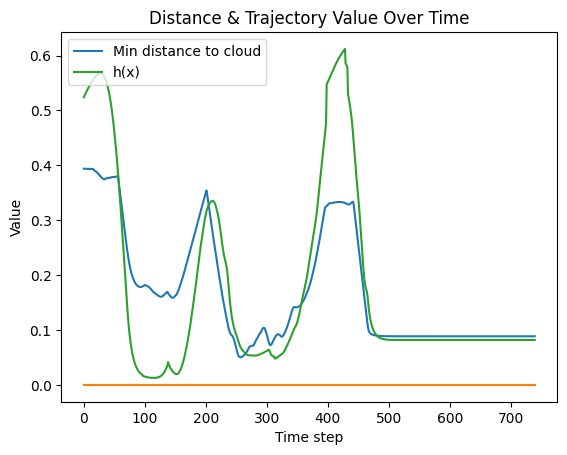

In [ ]:
# 3) plot
plt.figure()
plt.plot(min_dists,                 label='Min distance to cloud')
plt.plot(vs.cpu().detach().numpy(), label='h(x) (all SDFs)')
plt.plot(zeros.numpy())
plt.plot((trajectory_values),         label='h(x)')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('Distance & Trajectory Value Over Time')
plt.legend(loc='upper left')   # or wherever it looks best
plt.show()


In [52]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch

%matplotlib inline

def plot_2d_grid_with_model(x_range, y_range, steps, model, points=None, z_level=0, z_div=None, arrows=None):
    # Generate x and y linspace
    x_values = torch.linspace(*x_range, steps)
    y_values = torch.linspace(*y_range, steps)
    X, Y = torch.meshgrid(x_values, y_values, indexing="ij")
    
    # Flatten the grid for model input
    flattened_X = X.flatten()
    flattened_Y = Y.flatten()
    flattened_Z = torch.full_like(flattened_X, z_level)
    
    # Prepare inputs for the model
    xy_inputs = torch.stack([flattened_X, flattened_Y, flattened_Z], dim=1)
    z_inputs = torch.full((xy_inputs.shape[0], 1), z_div.item())

    output = model(xy_inputs, z_inputs)
    Z = output.view(steps, steps).detach().cpu().numpy()

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6))
    norm = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
    # norm = mcolors.TwoSlopeNorm(vmin=-1e-10, vcenter=0, vmax=1e-10)
    c = ax.pcolormesh(X.numpy(), Y.numpy(), Z, shading='auto', cmap='bwr', norm=norm)
    plt.colorbar(c, ax=ax, label='Model Output')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('2D Grid of Model Outputs')

    # Plot individual points if provided
    if points:
        for point in points:
            print("Point V", point, model(torch.tensor([point]), z_div.unsqueeze(0)).cpu().tolist())
        points_x, points_y, points_z = zip(*points)  # Unpack the points into x and y coordinates
        ax.scatter(points_x, points_y, color='green', s=50, label='Points')

    # Plot the arrow if provided
    if arrows:
        for arrow in arrows:
            (x_start, y_start), (x_end, y_end), color = arrow
            ax.arrow(x_start, y_start, x_end - x_start, y_end - y_start, 
                    head_width=0.2, head_length=0.3, fc=color, ec=color, linewidth=2, label='Arrow')

    # Add legend if points or arrow are plotted
    if points or arrows:
        ax.legend()

    plt.savefig("cylinder_safety.png")
    plt.show()

# Example usage
# model.upper_bound = 15
width = 5
t = int(slider.value)

# point.positions = [-20.5, 39.2, 3]
new_interactive_point.point = point.positions
# new_interactive_point.point[2] = -0.99
# print(new_interactive_point.point)

# new_interactive_point.point = small_pcd.mean(axis=0)
# new_interactive_point.point[2] = -0

print(new_interactive_point.point)

arrow_start = (new_interactive_point.point[0], new_interactive_point.point[1])
arrow_end = (new_interactive_point.point[0] + trajectory_us[t][0], new_interactive_point.point[1] + trajectory_us[t][1])
arrow_u = (arrow_start, arrow_end, 'black')

arrow_start = (new_interactive_point.point[0], new_interactive_point.point[1])
arrow_end = (new_interactive_point.point[0] + trajectory_urefs[t][0], new_interactive_point.point[1] + trajectory_urefs[t][1])
arrow_uref = (arrow_start, arrow_end, 'green')

plot_2d_grid_with_model(
    x_range=(new_interactive_point.point[0] - width, new_interactive_point.point[0] + width),
    y_range=(new_interactive_point.point[1] - width, new_interactive_point.point[1] + width),
    steps=200,
    z_div = z_div,
    model=model,
    z_level=new_interactive_point.point[2],
    points=[new_interactive_point.point],
    # points=[[1, 1.1,-1.1]],
    arrows=[arrow_u, arrow_uref]
)

NameError: name 'new_interactive_point' is not defined

[ 1.0941024  2.9092493 -1.3      ]
Point V [ 1.0941024  2.9092493 -1.3      ] [0.11448931694030762]
Point V [ 1.0941024  2.9092493 -1.3      ] [0.11448931694030762]


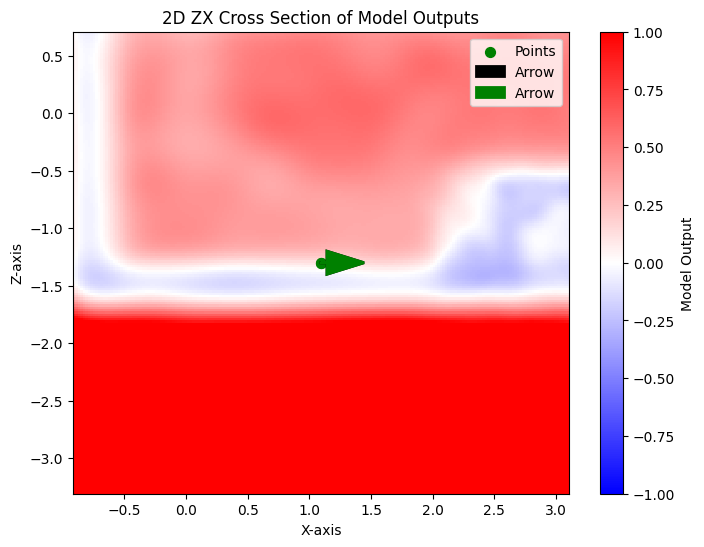

In [ ]:
import numpy as np

def plot_2d_grid_zx_section(x_range, z_range, steps, model, points=None, y_level=0, z_div=None, arrows=None):
    # Generate x and z linspace
    x_values = torch.linspace(*x_range, steps)
    z_values = torch.linspace(*z_range, steps)
    X, Z = torch.meshgrid(x_values, z_values, indexing="ij")
    
    # Flatten the grid for model input.
    # We fix y to the given y_level.
    flattened_X = X.flatten()
    flattened_Z = Z.flatten()
    flattened_Y = torch.full_like(flattened_X, y_level)
    
    # Prepare inputs for the model: note the order [x, y, z]
    inputs = torch.stack([flattened_X, flattened_Y, flattened_Z], dim=1)
    z_inputs = torch.full((inputs.shape[0], 1), z_div.item())

    output = model(inputs, z_inputs)
    output_grid = output.view(steps, steps).detach().cpu().numpy()

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6))
    norm = mcolors.TwoSlopeNorm(vmin=-model.upper_bound, vcenter=0, vmax=model.upper_bound)
    # norm = mcolors.TwoSlopeNorm(vmin=-1e-10, vcenter=0, vmax=1e-10)
    c = ax.pcolormesh(X.numpy(), Z.numpy(), output_grid, shading='auto', cmap='bwr', norm=norm)
    plt.colorbar(c, ax=ax, label='Model Output')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Z-axis')
    ax.set_title('2D ZX Cross Section of Model Outputs')

    # Plot individual points if provided (using x and z coordinates)
    if points:
        for point in points:
            print("Point V", point, model(torch.tensor([point]), z_div.unsqueeze(0)).cpu().tolist())
        # Unpack points (assumed to be (x, y, z) tuples) and plot using x and z.
        points_x, points_y, points_z = zip(*points)
        ax.scatter(points_x, points_z, color='green', s=50, label='Points')

    # Plot arrows if provided (arrows should be given in ZX coordinates)
    if arrows:
        for arrow in arrows:
            (x_start, z_start), (x_end, z_end), color = arrow
            ax.arrow(x_start, z_start, x_end - x_start, z_end - z_start, 
                     head_width=0.2, head_length=0.3, fc=color, ec=color, linewidth=2, label='Arrow')

    if points or arrows:
        ax.legend()

    plt.savefig("cylinder_safety_zx.png")
    plt.show()

print(point.positions)

arrow_start = (point.positions[0], point.positions[2])
arrow_end = (point.positions[0] + trajectory_us[t][0], point.positions[2] + trajectory_us[t][2])
arrow_u = (arrow_start, arrow_end, 'black')

arrow_start = (point.positions[0], point.positions[2])
arrow_end = (point.positions[0] + trajectory_urefs[t][0], point.positions[2] + trajectory_urefs[t][2])
arrow_uref = (arrow_start, arrow_end, 'green')

# Example usage
# model.upper_bound = 15
width = 2
t = int(slider.value)

# positions = [-20, 40, 0.6]
positions = point.positions

plot_2d_grid_zx_section(
    x_range=(new_interactive_point.point[0] - width, new_interactive_point.point[0] + width),
    z_range=(new_interactive_point.point[2] - width, new_interactive_point.point[2] + width),
    steps=200,
    z_div = z_div,
    model=model,
    y_level=new_interactive_point.point[1],
    points=[new_interactive_point.point, positions],
    arrows=[arrow_u, arrow_uref]
)

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# import torch

# %matplotlib inline

# def plot_2d_grid_with_model(x_range, y_range, steps, model, points=None, z_level=0, z_div=None, arrows=None):
#     # Generate x and y linspace
#     x_values = torch.linspace(*x_range, steps)
#     y_values = torch.linspace(*y_range, steps)
#     X, Y = torch.meshgrid(x_values, y_values, indexing="ij")
    
#     # Flatten the grid for model input
#     flattened_X = X.flatten()
#     flattened_Y = Y.flatten()
#     flattened_Z = torch.full_like(flattened_X, z_level)
    
#     # Prepare inputs for the model
#     xy_inputs = torch.stack([flattened_X, flattened_Y, flattened_Z], dim=1)
#     z_inputs = torch.full((xy_inputs.shape[0], 1), z_div.item())

#     output = model(xy_inputs, z_inputs)
#     # output = torch.clamp(output, max=model.upper_bound, min=-model.upper_bound)
#     Z = output.view(steps, steps).detach().numpy()

#     # Plotting
#     fig, ax = plt.subplots(figsize=(8, 6))
#     norm = mcolors.TwoSlopeNorm(vmin=min(-model.upper_bound, -0.5), vcenter=0, vmax=1)
#     c = ax.pcolormesh(X.numpy(), Y.numpy(), Z, shading='auto', cmap='bwr', norm=norm)
#     plt.colorbar(c, ax=ax, label='Model Output')
#     ax.set_xlabel('X-axis')
#     ax.set_ylabel('Y-axis')
#     ax.set_title('2D Grid of Model Outputs')

#     # Plot individual points if provided
#     if points:
#         for point in points:
#             print("Point V", point, model(torch.tensor([point]), z_div.unsqueeze(0), calc_jacobian=False).cpu().tolist())
#         points_x, points_y, points_z = zip(*points)  # Unpack the points into x and y coordinates
#         ax.scatter(points_x, points_y, color='green', s=50, label='Points')

#     # Plot the arrow if provided
#     if arrows:
#         for arrow in arrows:
#             (x_start, y_start), (x_end, y_end), color = arrow
#             ax.arrow(x_start, y_start, x_end - x_start, y_end - y_start, 
#                     head_width=0.2, head_length=0.3, fc=color, ec=color, linewidth=2, label='Arrow')

#     # Add legend if points or arrow are plotted
#     if points or arrows:
#         ax.legend()

#     plt.savefig("cylinder_safety.png")
#     plt.show()

# # Example usage
# # model.upper_bound = 15
# width = 4
# center = [-18, 39]
# plot_2d_grid_with_model(
#     x_range=(center[0] - width, center[0] + width),
#     y_range=(center[1] - width, center[1] + width),
#     steps=200,
#     z_div = z_div,
#     model=model,
#     z_level=0.6,
#     points = [[-15.867135,38.902016,0.5692017]]
# )